### Data Scientist Project - Seattle AirBnB Data

The purpose of the below code is to perform a data analysis on the Seattle's AirBnb data and answer the below questions

##### Question 1: 
Is the Seattle a seasonal visit attraction?

##### Question 2:
Are the cancellation policy, the reviews and the neighboorhood correlated with the booking count?

##### Question 3:
Which are the key indicators of an listing price?

In [6]:
#import all the needed libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import AllTogether as t
%matplotlib inline

In [7]:
#set the width of the column
pd.options.display.max_colwidth = 50

In order to process the files, i uploaded them in Jupyter notebook under folder AirBNBSeattleData

In [29]:
#read the CSV files from the folder and store them to pandas dataframes
df_calendar = pd.read_csv('./AirBNBSeattleData/calendar.csv')
df_listings = pd.read_csv('./AirBNBSeattleData/listings.csv')
df_reviews = pd.read_csv('./AirBNBSeattleData/reviews.csv')

First step is to try and understand the available data

In [6]:
#check the calendat df
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [11]:
#check the listings df
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https:...,201601...,2016-0...,Stylis...,NaN,Make y...,Make y...,none,NaN,...,10.0,f,NaN,WASHIN...,f,moderate,f,f,2,4.07
1,953595,https:...,201601...,2016-0...,Bright...,Chemic...,Beauti...,Chemic...,none,Queen ...,...,10.0,f,NaN,WASHIN...,f,strict,t,t,6,1.48
2,3308979,https:...,201601...,2016-0...,New Mo...,New mo...,Our ho...,New mo...,none,Upper ...,...,10.0,f,NaN,WASHIN...,f,strict,f,f,2,1.15
3,7421966,https:...,201601...,2016-0...,Queen ...,A char...,NaN,A char...,none,NaN,...,NaN,f,NaN,WASHIN...,f,flexible,f,f,1,NaN
4,278830,https:...,201601...,2016-0...,Charmi...,Cozy f...,Cozy f...,Cozy f...,none,We are...,...,9.0,f,NaN,WASHIN...,f,strict,f,f,1,0.89


In [12]:
#check the reviews df
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-0...,28943674,Bianca,Cute a...
1,7202016,39087409,2015-0...,32440555,Frank,Kelly ...
2,7202016,39820030,2015-0...,37722850,Ian,Very s...
3,7202016,40813543,2015-0...,33671805,George,Close ...
4,7202016,41986501,2015-0...,34959538,Ming,Kelly ...


Check the shape of the datasets

In [14]:
df_calendar.shape

(1393570, 4)

In [15]:
df_reviews.shape

(84849, 6)

In [16]:
df_listings.shape

(3818, 92)

##### Question 1: 
Is the Seattle a seasonal visit attraction?

It seems that we are in position to answer the 1st question, as the Calendars data provide a view of the bookings of all the appartments in Seaattle together with the data period.

We will process further the dataframe in order to understand it better

In [28]:
#Get the maximum and minimum dates
df_calendar[['date']].agg(['max', 'min'])

,date
max,2017-01-02
min,2016-01-04


In [47]:
#Perform a count aggregation in the date column, to check that we have data for all the months in between
pd.DatetimeIndex(df_calendar['date']).month.value_counts().sort_index()

1     114540
2     110722
3     118358
4     114540
5     118358
6     114540
7     118358
8     118358
9     114540
10    118358
11    114540
12    118358
Name: date, dtype: int64

In [33]:
set(df_calendar.columns[df_calendar.isnull().mean()==0])

{'available', 'date', 'listing_id'}

From the above analysis it seems that the calendar dataframe:

1. Has data for a full year
2. Has similar amount of data for all the months
3. Has available all the values for the columns we plan to use 'available' and 'date'

In [108]:
#Drop the not needed columns and store in a new dataframe
bookings_per_month = df_calendar.drop(['listing_id', 'price'], axis=1)
#Count the bookings per date
bookings_per_month = bookings_per_month[bookings_per_month['available']=='f'].groupby('date').count()
#Name the new column as Bookings_Count
bookings_per_month = bookings_per_month.reset_index().rename(columns={"available": "Bookings_Count"})
#Check the results
bookings_per_month.head()

,date,Bookings_Count
0,2016-01-04,2083
1,2016-01-05,1951
2,2016-01-06,1992
3,2016-01-07,2042
4,2016-01-08,2036


In [109]:
#Introduce the month column
bookings_per_month['month'] = pd.DatetimeIndex(bookings_per_month['date']).month
#Drop the date column
bookings_per_month = bookings_per_month.drop(['date'], axis=1)
#Sum the bookings per month
bookings_per_month = bookings_per_month.groupby('month', as_index=False).sum()
#bookings_per_month = bookings_per_month.reset_index().rename(columns={"available": "Bookings_Count"})
#Check the results
bookings_per_month.head()

,month,Bookings_Count
0,1,49603
1,2,37401
2,3,34420
3,4,38503
4,5,38387


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

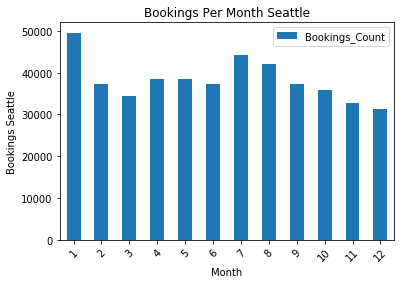

In [113]:
#Plot a barchart with the breakdown per months
#Sum per months and use it as index. Store in a plot dataframe
plot_df = bookings_per_month.groupby('month', as_index=True).sum()
(plot_df).plot(kind="bar");
plt.title("Bookings Per Month Seattle");
plt.xlabel("Month")
plt.ylabel("Bookings Seattle")
plt.xticks(rotation=45, horizontalalignment="center")

It seems that the January is a high booking month for Seattle, maybe it is related many visitis for NYE vacations or there are some famous events at that period.

Other high booking months are the July and August, maybe the good weather is related.

It would be interesting to check in Season level also the above breakdown

In [114]:
#Prepare the condition for the month values to be makred as segments
conditions = [
    ((bookings_per_month['month']==12)|(bookings_per_month['month']==1)|(bookings_per_month['month']==2)),
    ((bookings_per_month['month']==3)|(bookings_per_month['month']==4)|(bookings_per_month['month']==5)),
    ((bookings_per_month['month']==6)|(bookings_per_month['month']==7)|(bookings_per_month['month']==8)),
    ((bookings_per_month['month']==9)|(bookings_per_month['month']==10)|(bookings_per_month['month']==11))
    ]

#The different segment values are the 4 seasons
values = ['Winter', 'Spring', 'Summer', 'Fall']

#Create the Season column
bookings_per_month['Season'] = np.select(conditions, values)
bookings_per_month.head()

,month,Bookings_Count,Season
0,1,49603,Winter
1,2,37401,Winter
2,3,34420,Spring
3,4,38503,Spring
4,5,38387,Spring


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

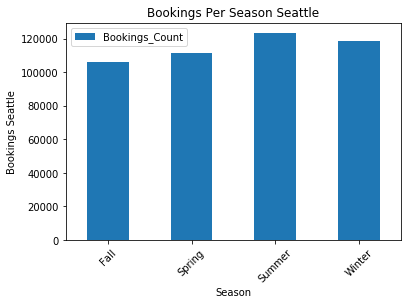

In [115]:
#Plot a barchart with the breakdown per season
#Drop the month column and store in a plot 2 dataframe
plot_df_2 = bookings_per_month.drop(['month'], axis=1)
#Sum the bookings per season and use the 
plot_df_2 = plot_df_2.groupby('Season', as_index=True).sum()
(plot_df_2).plot(kind="bar");
plt.title("Bookings Per Season Seattle");
plt.xlabel("Season")
plt.ylabel("Bookings Seattle")
plt.xticks(rotation=45, horizontalalignment="center")

It seems that the top booking seasons are Summer and Winter. It is maybe related with the people vacation perios

It would be interesting to compare these results with another city to see the difference. In the below cells we are reading the Boston AirBnB data and perform the same steps as above for Seattle. 

I will put all the code together and without comments, in order to run quickly

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

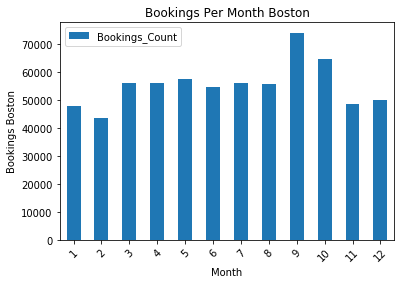

In [118]:
#In order to process the files, i uploaded them in Jupyter notebook under folder AirBNBBostonData
#read the CSV files from the folder
df_calendar_Boston = pd.read_csv('./AirBNBBostonData/calendar.csv')
df_listings_Boston = pd.read_csv('./AirBNBBostonData/listings.csv')
df_reviews_Boston = pd.read_csv('./AirBNBBostonData/reviews.csv')

#Get the number of rows and columns per dataset
df_listings_Boston.shape
#3585, 95
df_calendar_Boston.shape
#1308890, 4

#Get the minimum and maximum dates of the calendar dataset
df_calendar_Boston[['date']].agg(['max', 'min'])
#2016-09-06
#2017-09-05

#How many columns have no missing values
set(df_calendar_Boston.columns[df_calendar_Boston.isnull().mean()==0])
#{'available', 'date', 'listing_id'}

bookings_per_month_Boston = df_calendar_Boston[df_calendar_Boston['available']=='f'].groupby('date').count()
bookings_per_month_Boston = bookings_per_month_Boston.reset_index().rename(columns={"available": "Bookings_Count"})
bookings_per_month_Boston['month'] = pd.DatetimeIndex(bookings_per_month_Boston['date']).month
bookings_per_month_Boston = bookings_per_month_Boston.drop(['listing_id', 'price','date'], axis=1)
bookings_per_month_Boston = bookings_per_month_Boston.groupby('month', as_index=False).sum()

plot_df_Boston = bookings_per_month_Boston.groupby('month', as_index=True).sum()
(plot_df_Boston).plot(kind="bar");
plt.title("Bookings Per Month Boston");
plt.xlabel("Month")
plt.ylabel("Bookings Boston")
plt.xticks(rotation=45, horizontalalignment="center")

It seems that in Boston the high booking months are the September and October. Let's see also on Season level

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

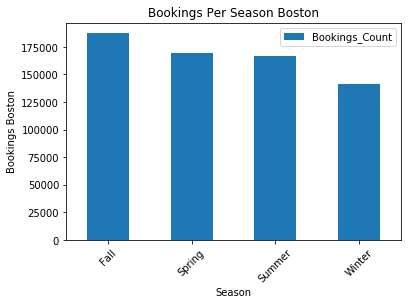

In [119]:
#Prepare the condition for the month values to be makred as segments
conditions = [
    ((bookings_per_month_Boston['month']==12)|(bookings_per_month_Boston['month']==1)|(bookings_per_month_Boston['month']==2)),
    ((bookings_per_month_Boston['month']==3)|(bookings_per_month_Boston['month']==4)|(bookings_per_month_Boston['month']==5)),
    ((bookings_per_month_Boston['month']==6)|(bookings_per_month_Boston['month']==7)|(bookings_per_month_Boston['month']==8)),
    ((bookings_per_month_Boston['month']==9)|(bookings_per_month_Boston['month']==10)|(bookings_per_month_Boston['month']==11))
    ]

#The different segment values are the 4 seasons
values = ['Winter', 'Spring', 'Summer', 'Fall']

#Create the Season column
bookings_per_month_Boston['Season'] = np.select(conditions, values)

#Plot a barchart with the breakdown per season
#Drop the month column and store in a plot 2 dataframe
plot_df_2_Boston = bookings_per_month_Boston.drop(['month'], axis=1)
#Sum the bookings per season and use the 
plot_df_2_Boston = plot_df_2_Boston.groupby('Season', as_index=True).sum()
(plot_df_2_Boston).plot(kind="bar");
plt.title("Bookings Per Season Boston");
plt.xlabel("Season")
plt.ylabel("Bookings Boston")
plt.xticks(rotation=45, horizontalalignment="center")

You can see the difference in the distrubition for the two cities. In Boston the high booking season is Fall and the Sprint, it is completely the opposite from Seattle. Boston has more visits during not vacation periods.

##### Question 2:
Are the cancellation policy, the reviews and the neighboorhood correlated with the booking count?

In order to answer this question we will need to join the booking count data calculated above with the listing datafram using the ID from listing dataframe and Listing ID from Calendar Dataframe.

Then we will do the breakdown for the 3 different attributes (cancellation policy, reviews and neighboorhood)

In [188]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [189]:
#Drop the not needed columns and store on a new dataframe
bookings_per_listing = df_calendar.drop(['date', 'price'], axis=1)
#Calculate bookings count for each listing
bookings_per_listing = bookings_per_listing[df_calendar['available']=='f'].groupby('listing_id').count()
#Create the new column named 
bookings_per_listing = bookings_per_listing.reset_index().rename(columns={"available": "Bookings_Count"})
#Left join the Bookings_Count column with the df_listings dataframe using the correlation listing_id and id
df_listings = df_listings.join(bookings_per_listing.set_index('listing_id'), on='id', how='left')
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Bookings_Count
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,19.0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,74.0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,f,NaN,WASHINGTON,f,strict,f,f,2,1.15,145.0
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN,222.0
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,f,NaN,WASHINGTON,f,strict,f,f,1,0.89,NaN


In [165]:
#Verify that the shape of df_listings is increase by one column and we did not lose any rows
df_listings.shape

(3818, 93)

Now we are ready to check the correlation between booking counts and cancellation policy

In [166]:
#Check how many null values we have
df_listings['cancellation_policy'].isnull().mean()

0.0

In [167]:
#Breakdown of the different cancellation policies
df_listings['cancellation_policy'].value_counts()

strict      1417
moderate    1251
flexible    1150
Name: cancellation_policy, dtype: int64

In [168]:
#Early bookings count per cancellation policy
df_listings.groupby('cancellation_policy')['Bookings_Count'].sum()

cancellation_policy
flexible    144427.0
moderate    156800.0
strict      157801.0
Name: Bookings_Count, dtype: float64

In order to check the correlation of the 2 attributes, we will need to normalize the results.
Hence we will perofrm the division of the total bookings counts with the amount of the listings per cancellaion policy type

In [170]:
#Calculate the average booking counts per apparment on each cancellation policy and store on a new df
bookings_per_appartment_per_cancellation = df_listings.groupby('cancellation_policy')['Bookings_Count'].sum()/df_listings['cancellation_policy'].value_counts()
bookings_per_appartment_per_cancellation.head()

flexible    125.588696
moderate    125.339728
strict      111.362738
dtype: float64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

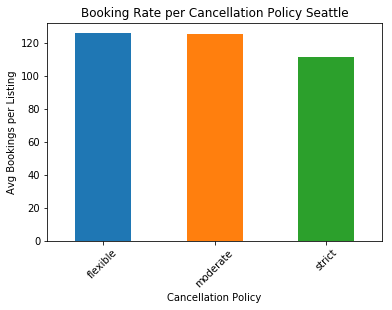

In [171]:
#Plot the results
(bookings_per_appartment_per_cancellation).plot(kind="bar");
plt.title("Booking Rate per Cancellation Policy Seattle");
plt.xlabel("Cancellation Policy")
plt.ylabel("Avg Bookings per Listing")
plt.xticks(rotation=45, horizontalalignment="center")

We can see that the sctrict cancellation policy has the lower average while the flexible the highest

Now we are ready to check the correlation between booking counts and Review Rates

In [216]:
#Check how many null values we have
df_listings['review_scores_value'].isnull().mean()

0.17181770560502882

In [217]:
#Check how many null values we have
df_listings['review_scores_value'].isnull().sum()

656

In [218]:
df_listings['review_scores_value'].value_counts().sort_index()

2.0        1
4.0        4
5.0        1
6.0       16
7.0       38
8.0      190
9.0     1137
10.0    1775
Name: review_scores_value, dtype: int64

As we have 17% not available review scores, we should either remove the rows or replace the null values. 

Because there is a big distribution towards high scores, i will go with the remove option.

In [219]:
#Create a new df from listings df
bookings_per_review_score = df_listings[['Bookings_Count','review_scores_value']]
bookings_per_review_score = bookings_per_review_score.dropna(subset=['review_scores_value'], axis=0)
bookings_per_review_score['review_scores_value'].value_counts().sort_index()

2.0        1
4.0        4
5.0        1
6.0       16
7.0       38
8.0      190
9.0     1137
10.0    1775
Name: review_scores_value, dtype: int64

In [220]:
#Check the total bookings per review rate
bookings_per_review_score.groupby('review_scores_value')['Bookings_Count'].sum()

review_scores_value
2.0        308.0
4.0        707.0
5.0         95.0
6.0       1681.0
7.0       4429.0
8.0      19004.0
9.0     115800.0
10.0    223678.0
Name: Bookings_Count, dtype: float64

We can see that the high score reviews (9,10) have too many bookings. For this reason we will use segmentations instead of the real values

In [221]:
#Set the segments
conditions = [
    (bookings_per_review_score['review_scores_value']<=8),
    (bookings_per_review_score['review_scores_value']==9),
    (bookings_per_review_score['review_scores_value']==10)
    ]

values = ['<=8', '9', '10']

#Create a new column named review_scores_segments as per the above conditions
bookings_per_review_score['review_scores_segments'] = np.select(conditions, values)
bookings_per_review_score.head()

,Bookings_Count,review_scores_value,review_scores_segments
0,19.0,10.0,10
1,74.0,10.0,10
2,145.0,10.0,10
4,NaN,9.0,9
5,63.0,10.0,10


Again the correlation will be calculated with normalized results

In [222]:
bookings_per_review_score = bookings_per_review_score.groupby('review_scores_segments')['Bookings_Count'].sum()/bookings_per_review_score['review_scores_segments'].value_counts()
bookings_per_review_score.head()

review_scores_segments
10     126.015775
9      101.846966
<=8    104.896000
dtype: float64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

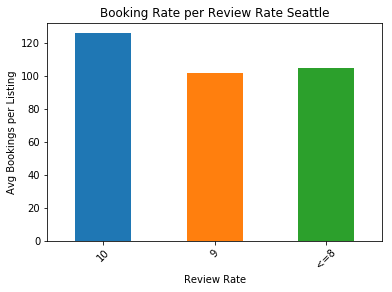

In [223]:
(bookings_per_review_score).plot(kind="bar");
plt.title("Booking Rate per Review Rate Seattle");
plt.xlabel("Review Rate")
plt.ylabel("Avg Bookings per Listing")
plt.xticks(rotation=45, horizontalalignment="center")

The review rates 10 have higher booking counts as expected.
Though, it is strange as it seems that the review rates with '<=8' or lower have greater booking counts than 9. Maybe there are other factors that are more important or maybe the data amount for the segment '<=8' are not enough to have a proper answer.

Now we can go and check the correlation between booking count and neighbourhood

In [199]:
#Pick columns Bookings_Count and neighbourhood_group_cleansed and store on a new dataframe
bookings_per_neighbourhood = df_listings[['Bookings_Count','neighbourhood_group_cleansed']]
bookings_per_neighbourhood.head()

,Bookings_Count,neighbourhood_group_cleansed
0,19.0,Queen Anne
1,74.0,Queen Anne
2,145.0,Queen Anne
3,222.0,Queen Anne
4,NaN,Queen Anne


In [201]:
#Check how many null values we have
bookings_per_neighbourhood['neighbourhood_group_cleansed'].isnull().mean()

0.0

In [204]:
#Check the count of listings per neighbourhood group
bookings_per_neighbourhood['neighbourhood_group_cleansed'].value_counts().sort_index()

Ballard                230
Beacon Hill            118
Capitol Hill           567
Cascade                 89
Central Area           369
Delridge                79
Downtown               530
Interbay                11
Lake City               67
Magnolia                61
Northgate               80
Other neighborhoods    794
Queen Anne             295
Rainier Valley         159
Seward Park             44
University District    122
West Seattle           203
Name: neighbourhood_group_cleansed, dtype: int64

In [205]:
#Check the amount of bookings per neighbourhood group
bookings_per_neighbourhood.groupby('neighbourhood_group_cleansed')['Bookings_Count'].sum()

neighbourhood_group_cleansed
Ballard                25835.0
Beacon Hill            12800.0
Capitol Hill           74287.0
Cascade                13768.0
Central Area           44129.0
Delridge                7290.0
Downtown               67725.0
Interbay                 621.0
Lake City               5654.0
Magnolia                5017.0
Northgate               8095.0
Other neighborhoods    95149.0
Queen Anne             40871.0
Rainier Valley         19121.0
Seward Park             5139.0
University District    11382.0
West Seattle           22145.0
Name: Bookings_Count, dtype: float64

We will proceed with normalization of the data

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

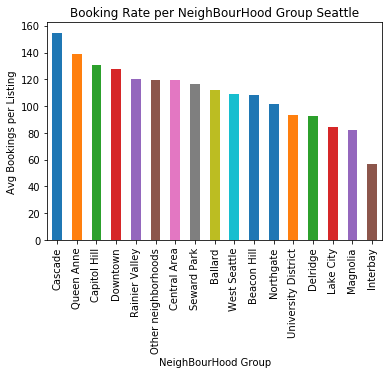

In [225]:
#Normalize the data per appartment
norm_bookings_per_neighbourhood = bookings_per_neighbourhood.groupby('neighbourhood_group_cleansed')['Bookings_Count'].sum()/bookings_per_neighbourhood['neighbourhood_group_cleansed'].value_counts()

#Sort the results based on the amount of booking rate
norm_bookings_per_neighbourhood = norm_bookings_per_neighbourhood.sort_values(axis=0, ascending=False)

#Plot the results
(norm_bookings_per_neighbourhood).plot(kind="bar");
plt.title("Booking Rate per NeighBourHood Group Seattle");
plt.xlabel("NeighBourHood Group")
plt.ylabel("Avg Bookings per Listing")
plt.xticks(horizontalalignment="center")

You can see that there are some specific neighbourhood groups much more popular than others

##### Question 3:
Which are the key indicators of an appartment price?

In [30]:
#Store listings dataframe to a new df
df_listings_model = df_listings

In order to answer the above question we will build a machine learning model and we will try to predict the price of each listing based on its characteristics

I will create a function which will be able to exclude the fields with big or low variance

In [31]:
#Function to isolate columns with very big or very small variance (>=1000 or <=2)
def find_proper_columns (df,min_var,max_var):
    exclude_columns = []
    for i in df_listings.columns:
        if ((df[i].value_counts().count()>=max_var)|(df[i].value_counts().count()<=min_var)):
            exclude_columns.append(i)
            #print (i,df_listings[i].value_counts().count())
    find_proper_columns.exclude_columns = exclude_columns 

I will run the function by setting the relevant minimum and maximum values

In [32]:
#Run the function using the listings dataframe
find_proper_columns(df_listings_model,2,1000)
find_proper_columns.exclude_columns[:5]

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name']

In [33]:
len(find_proper_columns.exclude_columns)

44

Exclude the columns that have more than 30% null values

In [34]:
#Find columns with more than 30% null values
exclude_mean = list(set(df_listings_model.columns[df_listings_model.isnull().mean()>0.30]))
exclude_mean[:5]

['notes', 'security_deposit', 'weekly_price', 'monthly_price', 'license']

In [35]:
len(exclude_mean)

6

Create 2 functions that do the below:

    1. Transform a list of columns from string to numeric
    2. Transform a list of columns from sting dates to numeric values with the logic now() - date

In [36]:
#the function to remove non-numeric chars from numeric columns
def str_to_numeric(df,str_to_numeric_list):
    for i in str_to_numeric_list:
        df[i] = df[i].str.replace(',', '')
        df[i] = df[i].str.replace('$', '')
        df[i] = df[i].str.replace('%', '')
        df[i] = df[i].astype(float)

#the function to convert date values to days until today (numeric)
def date_to_days(df,date_to_days_list):
    for i in date_to_days_list:
        df[i] = pd.to_datetime(df[i])
        df[i]  = (pd.Timestamp.now().normalize() - df[i]).dt.days

Run the above functions by setting the columns of our interest

In [37]:
#Convert the below list to numbers
str_to_numeric_list = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people','host_response_rate']
str_to_numeric(df_listings_model,str_to_numeric_list)

#Convert the below list to days until today
date_to_days_list = ['first_review','last_review','host_since']
date_to_days(df_listings_model,date_to_days_list)

Create a function that will clean the dataset and run the linear regression model

In [46]:
#The function that calculates the model
def clean_fit_linear_mod(df_listings, response_col, drop_columns, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT
    df_listings
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df_listings using the following steps to produce X and y:
    1. Drop all the rows with no price
    2. Create X as all the columns that are not the price column
    3. Create y as the price column
    4. Drop the not needed columns from X using the drop_columns list
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing price values
    df_listings_predict_price = df_listings.dropna(subset=[response_col], axis=0)
    y = df_listings[response_col]
    
    #Drop price column
    df_listings_predict_price = df_listings_predict_price.drop([response_col], axis=1)
    #Drop not needed columns
    df_listings_predict_price = df_listings_predict_price.drop(drop_columns, axis=1)   
    
    # Fill numeric columns with the mean
    num_vars = df_listings_predict_price.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df_listings_predict_price[col].fillna((df_listings_predict_price[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df_listings_predict_price.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        df_listings_predict_price = pd.concat([df_listings_predict_price.drop(var, axis=1), pd.get_dummies(df_listings_predict_price[var], prefix=var, prefix_sep='_', drop_first=dummy_na)], axis=1)
    
    X = df_listings_predict_price
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=rand_state) 
    
    #Instantiate
    lm_model = LinearRegression(normalize=True) 
    #Fit
    lm_model.fit(X_train, y_train)
        
    #Predict and score the model
    y_train_preds = lm_model.predict(X_train)
    y_test_preds = lm_model.predict(X_test) 
    train_score = r2_score(y_train, y_train_preds)
    test_score = r2_score(y_test, y_test_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, X, y


Run the functions by preparing the drop columns lists

In [47]:
proper_columns = list(set(df_listings_model.columns) - set(find_proper_columns.exclude_columns)  - set(exclude_mean)
                    -set(['neighbourhood_group_cleansed','zipcode','host_location','smart_location'
                         ,'host_neighbourhood','neighbourhood','host_verifications','calendar_updated'
                         ]))

drop_columns = list(set(df_listings_model.columns) - set(proper_columns))

test_score, train_score, lm_model, X_train, X_test, y_train, y_test, X, y = clean_fit_linear_mod(df_listings_model, 'price', drop_columns, dummy_na=True)
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
len(X.columns)

The rsquared on the training data was 0.6279527836596475.  The rsquared on the test data was 0.6156268219804049.


146

Run the provided cutoff function

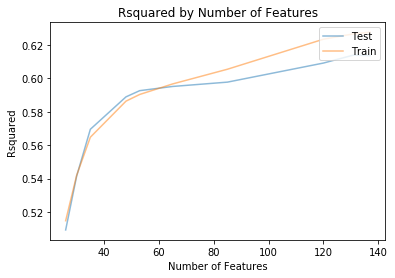

In [55]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 75, 50, 25, 10, 5, 2]

#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = t.find_optimal_lm_mod(X, y, cutoffs)

Check the best results that this model can give

In [56]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

131
0.614008648925
0.626740827187


In [61]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df
pd.options.display.max_colwidth = 1000

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(10)
#coef_df.tail(10)

,est_int,coefs,abs_coefs
2,host_total_listings_count,-1.299404e+12,1.299404e+12
1,host_listings_count,1.299404e+12,1.299404e+12
114,property_type_Boat,1.124299e+02,1.124299e+02
61,neighbourhood_cleansed_Industrial District,9.273483e+01,9.273483e+01
88,neighbourhood_cleansed_Pioneer Square,8.530955e+01,8.530955e+01
89,neighbourhood_cleansed_Portage Bay,8.441985e+01,8.441985e+01
98,neighbourhood_cleansed_Southeast Magnolia,8.221366e+01,8.221366e+01
87,neighbourhood_cleansed_Pike-Market,7.891436e+01,7.891436e+01
108,neighbourhood_cleansed_Westlake,7.099467e+01,7.099467e+01
124,room_type_Shared room,-6.292639e+01,6.292639e+01


Remove the really high and low coefficients and rerun the model

In [84]:
proper_columns = list(set(df_listings_model.columns) - set(find_proper_columns.exclude_columns)  - set(exclude_mean)
                    -set(['neighbourhood_group_cleansed','zipcode','host_location','smart_location'
                         ,'host_neighbourhood','neighbourhood','host_verifications','calendar_updated'
                          ,'host_total_listings_count','host_listings_count'
                          ,'maximum_nights','minimum_nights','city'
                          ,'availability_365','availability_60','availability_30'
                         ]))

drop_columns = list(set(df_listings_model.columns) - set(proper_columns))

test_score, train_score, lm_model, X_train, X_test, y_train, y_test, X, y = clean_fit_linear_mod(df_listings_model, 'price', drop_columns, dummy_na=True)
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
len(X.columns)

The rsquared on the training data was 0.6269146990549179.  The rsquared on the test data was 0.6165397947371682.


133

We can see from the above that by removing the really high and really low predictors the model reverted slightly better results

Rerun the coefficients after the improved run

In [88]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df
pd.options.display.max_colwidth = 1000

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#Check the higher predictors and the lower predictors
coef_df.head(10)
#coef_df.tail(30)

,est_int,coefs,abs_coefs
111,property_type_Boat,113.961453,113.961453
55,neighbourhood_cleansed_Industrial District,88.378330,88.378330
83,neighbourhood_cleansed_Pioneer Square,81.046332,81.046332
84,neighbourhood_cleansed_Portage Bay,79.645129,79.645129
96,neighbourhood_cleansed_Southeast Magnolia,78.742844,78.742844
81,neighbourhood_cleansed_Pike-Market,77.167540,77.167540
106,neighbourhood_cleansed_Westlake,66.628853,66.628853
82,neighbourhood_cleansed_Pinehurst,-62.422757,62.422757
126,room_type_Shared room,-61.343845,61.343845
117,property_type_Dorm,-56.633336,56.633336


In [89]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

133
0.614008648925
0.626740827187
